In [2]:
%config InlineBackend.figure_formats = ['svg']

In [154]:
from time import time

from functools import reduce

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit.quantum_info import Statevector
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver, MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

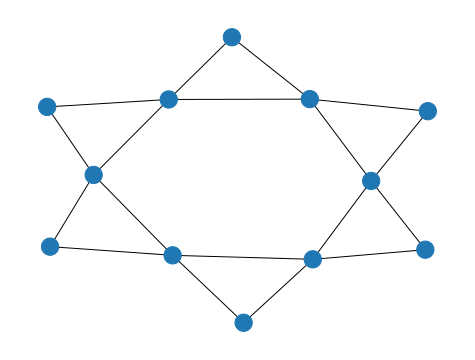

In [4]:
num_sites = 12
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (0, 2, t),
    (1, 2, t),
    (2, 3, t),
    (2, 4, t),
    (3, 4, t),
    (4, 5, t),
    (4, 6, t),
    (5, 6, t),
    (6, 7, t),
    (6, 8, t),
    (7, 8, t),
    (8, 9, t),
    (8, 10, t),
    (9, 10, t),
    (10, 11, t),
    (10, 0, t),
    (11, 0, t),
]
graph.add_edges_from(edge_list)
kagome_unit_cell = Lattice(graph)

kagome_unit_cell.draw()
plt.show()

In [5]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZIIIIIIIIII', 'IZZIIIIIIIII', 'IZIZIIIIIIII', 'IIZZIIIIIIII', 'IIIZZIIIIIII', 'IIIZIZIIIIII', 'IIIIZZIIIIII', 'IIIIIZZIIIII', 'IIIIIZIZIIII', 'IIIIIIZZIIII', 'IIIIIIIZZIII', 'IIIIIIIZIZII', 'IIIIIIIIZZII', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IZIIIIIIIIIZ', 'IIIIIIIIIZIZ', 'IIIIIIIIIIZZ', 'YYIIIIIIIIII', 'IYYIIIIIIIII', 'IYIYIIIIIIII', 'IIYYIIIIIIII', 'IIIYYIIIIIII', 'IIIYIYIIIIII', 'IIIIYYIIIIII', 'IIIIIYYIIIII', 'IIIIIYIYIIII', 'IIIIIIYYIIII', 'IIIIIIIYYIII', 'IIIIIIIYIYII', 'IIIIIIIIYYII', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IYIIIIIIIIIY', 'IIIIIIIIIYIY', 'IIIIIIIIIIYY', 'XXIIIIIIIIII', 'IXXIIIIIIIII', 'IXIXIIIIIIII', 'IIXXIIIIIIII', 'IIIXXIIIIIII', 'IIIXIXIIIIII', 'IIIIXXIIIIII', 'IIIIIXXIIIII', 'IIIIIXIXIIII', 'IIIIIIXXIIII', 'IIIIIIIXXIII', 'IIIIIIIXIXII', 'IIIIIIIIXXII', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IXIIIIIIIIIX', 'IIIIIIIIIXIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [6]:
exact_solver = ClassicalEigensolver(k=2**12)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = exact_result.eigenvalues[0]

[-18.         -18.         -16.96132284 ...  18.          18.
  18.        ]


In [ ]:
nonzero_amplitudes = [ sum(1 for amplitude in exact_result.eigenstates[i].primitive.data if not np.isclose(amplitude, 0)) for i in range(2**12) ]

In [83]:
nonzero_amplitudes = np.array(nonzero_amplitudes)

In [84]:
nonzero_amplitudes[0]

126

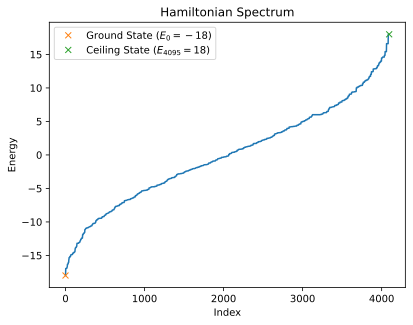

In [8]:
plt.plot(exact_result.eigenvalues)
plt.plot(0, exact_result.eigenvalues[0], 'x', label=f"Ground State ($E_0={exact_result.eigenvalues[0]:.0f}$)")
plt.plot(2**12-1, exact_result.eigenvalues[-1], 'x', label=f"Ceiling State ($E_{{4095}}={exact_result.eigenvalues[-1]:.0f}$)")
plt.title("Hamiltonian Spectrum")
plt.xlabel("Index")
plt.ylabel("Energy")
plt.legend()
plt.show()

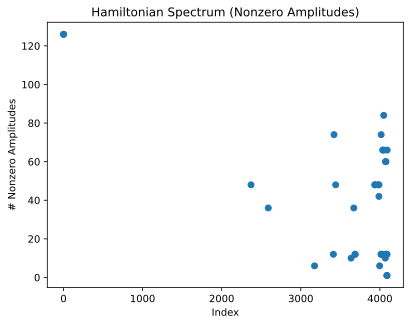

In [94]:
max_num_states = 130
plt.scatter(np.argwhere(nonzero_amplitudes < max_num_states), nonzero_amplitudes[nonzero_amplitudes < max_num_states])
plt.title("Hamiltonian Spectrum (Nonzero Amplitudes)")
plt.xlabel("Index")
plt.ylabel("# Nonzero Amplitudes")
# plt.legend()
plt.show()

In [174]:
exact_result.eigenstates[0].primitive.data[683]

(-0.10583086414737417+0j)

In [176]:
exact_result.eigenstates[1].primitive.data[1366]

(-0.1036968609981347+0j)

In [182]:
for amplitude in np.unique(exact_result.eigenstates[0].primitive.data.round(decimals=4)):
    print(f"{np.abs(amplitude)} {np.angle(amplitude)}")

0.1058 3.141592653589793
0.0699 3.141592653589793
0.0 0.0
0.0359 0.0
0.0699 0.0
0.1058 0.0


In [183]:
for amplitude in np.unique(exact_result.eigenstates[1].primitive.data.round(decimals=4)):
    print(f"{np.abs(amplitude)} {np.angle(amplitude)}")

0.1037 3.141592653589793
0.0666 3.141592653589793
0.0 0.0
0.0666 0.0
0.1037 0.0
0.1703 0.0


In [184]:
0.1058/0.0699

1.513590844062947

In [185]:
0.1037/0.0666

1.557057057057057

In [281]:
plus_states_0 = []
minus_states_0 = []
for state, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if np.isclose(np.abs(amplitude), np.abs(exact_result.eigenstates[0].primitive.data[683])):
        if np.isclose(np.angle(amplitude), 0):
            plus_states_0.append(state)
            print(f"+{np.abs(amplitude):.2f}|{state:0{num_sites}b}> ({state})")
        elif np.isclose(np.angle(amplitude), np.pi):
            minus_states_0.append(state)
            print(f"-{np.abs(amplitude):.2f}|{state:0{num_sites}b}> ({state})")
        else:
            raise RuntimeError()
print(f"Plus States: {len(plus_states_0)}, Minus States: {len(minus_states_0)}")

-0.11|001010101011> (683)
+0.11|001010101101> (685)
+0.11|001010110011> (691)
-0.11|001010110101> (693)
+0.11|001011001011> (715)
-0.11|001011001101> (717)
-0.11|001011010011> (723)
+0.11|001011010101> (725)
+0.11|001100101011> (811)
-0.11|001100101101> (813)
-0.11|001100110011> (819)
+0.11|001100110101> (821)
-0.11|001101001011> (843)
+0.11|001101001101> (845)
+0.11|001101010011> (851)
-0.11|001101010101> (853)
+0.11|010010101011> (1195)
-0.11|010010101101> (1197)
-0.11|010010110011> (1203)
+0.11|010010110101> (1205)
-0.11|010011001011> (1227)
+0.11|010011001101> (1229)
+0.11|010011010011> (1235)
-0.11|010011010101> (1237)
-0.11|010100101011> (1323)
+0.11|010100101101> (1325)
+0.11|010100110011> (1331)
-0.11|010100110101> (1333)
+0.11|010101001011> (1355)
-0.11|010101001101> (1357)
-0.11|010101010011> (1363)
-0.11|101010101100> (2732)
-0.11|101010110010> (2738)
+0.11|101010110100> (2740)
-0.11|101011001010> (2762)
+0.11|101011001100> (2764)
+0.11|101011010010> (2770)
-0.11|10101101010

In [282]:
plus_states_1 = []
minus_states_1 = []
for state, amplitude in enumerate(exact_result.eigenstates[1].primitive.data):
    if np.isclose(np.abs(amplitude), np.abs(exact_result.eigenstates[1].primitive.data[1366])):
        if np.isclose(np.angle(amplitude), 0):
            plus_states_1.append(state)
            print(f"+{np.abs(amplitude):.2f}|{state:0{num_sites}b}> ({state})")
        elif np.isclose(np.angle(amplitude), np.pi):
            minus_states_1.append(state)
            print(f"-{np.abs(amplitude):.2f}|{state:0{num_sites}b}> ({state})")
        else:
            raise RuntimeError()
print(f"Plus States: {len(plus_states_1)}, Minus States: {len(minus_states_1)}")

-0.10|010101010110> (1366)
-0.10|010101011001> (1369)
+0.10|010101011010> (1370)
-0.10|010101100101> (1381)
+0.10|010101100110> (1382)
+0.10|010101101001> (1385)
-0.10|010101101010> (1386)
-0.10|010110010101> (1429)
+0.10|010110010110> (1430)
+0.10|010110011001> (1433)
-0.10|010110011010> (1434)
+0.10|010110100101> (1445)
-0.10|010110100110> (1446)
-0.10|010110101001> (1449)
+0.10|010110101010> (1450)
-0.10|011001010101> (1621)
+0.10|011001010110> (1622)
+0.10|011001011001> (1625)
-0.10|011001011010> (1626)
+0.10|011001100101> (1637)
-0.10|011001100110> (1638)
-0.10|011001101001> (1641)
+0.10|011001101010> (1642)
+0.10|011010010101> (1685)
-0.10|011010010110> (1686)
-0.10|011010011001> (1689)
+0.10|011010011010> (1690)
-0.10|011010100101> (1701)
+0.10|011010100110> (1702)
+0.10|011010101001> (1705)
-0.10|011010101010> (1706)
-0.10|100101010101> (2389)
+0.10|100101010110> (2390)
+0.10|100101011001> (2393)
-0.10|100101011010> (2394)
+0.10|100101100101> (2405)
-0.10|100101100110> (2406)
-

In [284]:
plus_states = plus_states_0 + plus_states_1
minus_states = minus_states_0 + minus_states_1

print(f"# Plus States: {len(plus_states)}, # Minus States: {len(minus_states)}")

# Plus States: 60, # Minus States: 64


In [10]:
exact_result.eigenstates[0].primitive.data

array([ 0.00000000e+00+0.j,  4.04013083e-46+0.j, -1.77576077e-18+0.j, ...,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j])

In [6]:
random_sv = np.random.rand(2 ** 12)
random_sv = Statevector(random_sv / np.linalg.norm(random_sv))
random_sv.expectation_value(hamiltonian).real

13.496092074574413

$$|\psi\rangle=\frac1{\sqrt2}\left(|000000000000\rangle+|111111111111\rangle\right)$$
$$E=+18$$

In [7]:
sv = np.zeros(2**12)
for state in [0b000000000000, 0b111111111111]:
    sv[state] = 1
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian).real

17.999999999999996

$$|\psi\rangle=\frac1{\sqrt2}\left(|000000111111\rangle+|111111000000\rangle\right)$$
$$E=-6$$

In [8]:
sv = np.zeros(2**12)
for state in [0b000000111111, 0b111111000000]:
    sv[state] = 1
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian).real

-5.999999999999999

$$|\psi\rangle=\frac1{\sqrt2}\left(|000011111001\rangle+|000101110101\rangle\right)$$
$$E=-6$$

In [9]:
sv = np.zeros(2**12)
for state in [0b000011111001, 0b000101110101]:
    sv[state] = 1
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian).real

-5.999999999999999

$$|\psi\rangle=\frac1{\sqrt{62}}\left((|000011111001\rangle+|000101110101\rangle+|000110110011\rangle+|001001101101\rangle+|001010101011\rangle+|001100100111\rangle+|001111100001\rangle+|010001011101\rangle+|010010011011\rangle+|010100010111\rangle+|010111010001\rangle+|011000001111\rangle+|011011001001\rangle+|011101000101\rangle+|011110000011\rangle+|100001111100\rangle+|100010111010\rangle+|100100110110\rangle+|100111110000\rangle+|101000101110\rangle+|101011101000\rangle+|101101100100\rangle+|101110100010\rangle+|110000011110\rangle+|110011011000\rangle+|110101010100\rangle+|110110010010\rangle+|111001001100\rangle+|111010001010\rangle+|111100000110\rangle)-(|000001111101\rangle+|000010111011\rangle+|000100110111\rangle+|000111110001\rangle+|001000101111\rangle+|001011101001\rangle+|001101100101\rangle+|001110100011\rangle+|010000011111\rangle+|010011011001\rangle+|010101010101\rangle+|010110010011\rangle+|011001001101\rangle+|011010001011\rangle+|011100000111\rangle+|011111000001\rangle+|100000111110\rangle+|100011111000\rangle+|100101110100\rangle+|100110110010\rangle+|101001101100\rangle+|101010101010\rangle+|101100100110\rangle+|101111100000\rangle+|110001011100\rangle+|110010011010\rangle+|110100010110\rangle+|110111010000\rangle+|111000001110\rangle+|111011001000\rangle+|111101000100\rangle+|111110000010\rangle)\right)$$
$$E\approx -17.613$$

In [25]:
sv = np.zeros(2**12)
for state in plus_states_0:
    sv[state] = 1
for state in minus_states_0:
    sv[state] = -1
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian).real

-17.61290322580645

$$|\psi\rangle=\frac1{\sqrt{62}}\left((|000011111100\rangle+|000101111010\rangle+|000110111001\rangle+|001001110110\rangle+|001010110101\rangle+|001100110011\rangle+|001111110000\rangle+|010001101110\rangle+|010010101101\rangle+|010100101011\rangle+|010111101000\rangle+|011000100111\rangle+|011011100100\rangle+|011101100010\rangle+|011110100001\rangle+|100001011110\rangle+|100010011101\rangle+|100100011011\rangle+|100111011000\rangle+|101000010111\rangle+|101011010100\rangle+|101101010010\rangle+|101110010001\rangle+|110000001111\rangle+|110011001100\rangle+|110101001010\rangle+|110110001001\rangle+|111001000110\rangle+|111010000101\rangle+|111100000011\rangle)-(|000001111110\rangle+|000010111101\rangle+|000100111011\rangle+|000111111000\rangle+|001000110111\rangle+|001011110100\rangle+|001101110010\rangle+|001110110001\rangle+|010000101111\rangle+|010011101100\rangle+|010101101010\rangle+|010110101001\rangle+|011001100110\rangle+|011010100101\rangle+|011100100011\rangle+|011111100000\rangle+|100000011111\rangle+|100011011100\rangle+|100101011010\rangle+|100110011001\rangle+|101001010110\rangle+|101010010101\rangle+|101100010011\rangle+|101111010000\rangle+|110001001110\rangle+|110010001101\rangle+|110100001011\rangle+|110111001000\rangle+|111000000111\rangle+|111011000100\rangle+|111101000010\rangle+|111110000001\rangle)\right)$$
$$E\approx -17.613$$

In [26]:
sv = np.zeros(2**12)
for state in plus_states_1:
    sv[state] = 1
for state in minus_states_1:
    sv[state] = -1
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian).real

-17.61290322580645

In [28]:
for state in plus_states_0:
    print(f"{state:012b}")

001010101101
001010110011
001011001011
001011010101
001100101011
001100110101
001101001101
001101010011
010010101011
010010110101
010011001101
010011010011
010100101101
010100110011
010101001011
101010110100
101011001100
101011010010
101100101100
101100110010
101101001010
101101010100
110010101100
110010110010
110011001010
110011010100
110100101010
110100110100
110101001100
110101010010


In [169]:
def compose(*functions):
    return reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

def rotate(state):
    return (state >> 2)|(state << (num_sites - 2)) & 0b111111111111

def reflect(state):
    binary = f"{state:012b}"
    return int(binary[:-1][::-1] + binary[-1], 2)

def flip(state):
    return ~state & 0b111111111111

def equivalent_states(state):
    return frozenset([compose(*([rotate for _ in range(i)] + [reflect for _ in range(j)] + [flip for _ in range(k)]))(state) for i in range(6) for j in range(2) for k in range(2) ])

In [293]:
for state in equivalent_states(plus_states[0]):
    sv = np.zeros(2**12)
    sv[state] = 1
    sv = Statevector(sv / np.linalg.norm(sv))
    print(f"{state:012b} {sv.expectation_value(hamiltonian).real}")

011010010101 -6.0
101010010110 -6.0
010110100101 -6.0
101010100101 -6.0
011010101001 -6.0
010110101010 -6.0
010010101011 -6.0
110100101010 -6.0
001010101101 -6.0
010100101101 -6.0
101010110100 -6.0
010010110101 -6.0
101101001010 -6.0
010101001011 -6.0
110101010010 -6.0
101011010010 -6.0
101101010100 -6.0
101001010101 -6.0
100101010110 -6.0
001011010101 -6.0
101001011010 -6.0
010101011010 -6.0
010101101001 -6.0
100101101010 -6.0


In [ ]:
for state in range(2**11):
    inverted_state =  ~state & 0b111111111111

    sv = np.zeros(2**12)
    sv[state] = 1
    sv = Statevector(sv / np.linalg.norm(sv))

    inverted_sv = np.zeros(2**12)
    inverted_sv[state] = 1
    inverted_sv = Statevector(inverted_sv / np.linalg.norm(inverted_sv))

    state_ev = sv.expectation_value(hamiltonian)
    inverted_state_ev = inverted_sv.expectation_value(hamiltonian)

    if state_ev != inverted_state_ev:
        print(state_ev, inverted_state_ev)

In [274]:
# BIT FLIP SYMMETRY
plus_equivalence_classes = set()
for state in plus_states:
    plus_equivalence_classes.add(equivalent_states(state))
plus_equivalence_classes = [ set(equivalence_class) for equivalence_class in plus_equivalence_classes]

minus_equivalence_classes = set()
for state in minus_states:
    minus_equivalence_classes.add(equivalent_states(state))
minus_equivalence_classes = [ set(equivalence_class) for equivalence_class in minus_equivalence_classes]

print(f"# Plus Equivalence Classes: {len(plus_equivalence_classes)}, # Minus Equivalence Classes: {len(minus_equivalence_classes)}")
print(len(set(state for equivalence_class in plus_equivalence_classes for state in equivalence_class)), len(set(state for equivalence_class in minus_equivalence_classes for state in equivalence_class)))

# Plus Equivalence Classes: 3, # Minus Equivalence Classes: 4
60 64


In [292]:
minus_equivalence_classes[2]

{683,
 853,
 1237,
 1333,
 1357,
 1363,
 1366,
 1369,
 1381,
 1429,
 1621,
 1706,
 2389,
 2474,
 2666,
 2714,
 2726,
 2729,
 2732,
 2738,
 2762,
 2858,
 3242,
 3412}

In [278]:
set(plus_states) == set(state for equivalence_class in plus_equivalence_classes for state in equivalence_class)

True

In [285]:
set(minus_states) == set(state for equivalence_class in minus_equivalence_classes for state in equivalence_class)

True

In [287]:
set(plus_states).intersection(set(minus_states))

set()

In [280]:
len(minus_states)

64

In [218]:
for equivalence_class in plus_equivalence_classes:
    print(len(equivalence_class))

24
12
24


In [219]:
for equivalence_class in minus_equivalence_classes:
    print(len(equivalence_class))

24
4
24
12


In [212]:
reduced_plus_states = [min(list(list(plus_equivalence_classes)[0])), min(list(list(plus_equivalence_classes)[1])), min(list(list(plus_equivalence_classes)[2]))]
reduced_minus_states =  [min(list(list(minus_equivalence_classes)[0])), min(list(list(minus_equivalence_classes)[1])), min(list(list(minus_equivalence_classes)[2])), min(list(list(minus_equivalence_classes)[3]))]

print(reduced_plus_states, reduced_minus_states)

[685, 715, 691] [717, 819, 683, 693]


In [262]:
sv = np.zeros(2**12)
for state in [685, 725]:
    sv[state] = 1
sv = Statevector(sv/np.linalg.norm(sv))
print(sv.expectation_value(hamiltonian))

(-5.999999999999999+0j)


In [253]:
plus_equivalence_classes[0]

{685,
 725,
 1195,
 1205,
 1325,
 1355,
 1370,
 1385,
 1445,
 1450,
 1685,
 1705,
 2390,
 2410,
 2645,
 2650,
 2710,
 2725,
 2740,
 2770,
 2890,
 2900,
 3370,
 3410}

In [263]:
for equivalence_class in plus_equivalence_classes:
    for state in equivalence_class:
        sv = np.zeros(2**12)
        sv[state] = 1
        sv = Statevector(sv/np.linalg.norm(sv))
        print(sv.expectation_value(hamiltonian))
    print()

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)



In [265]:
for equivalence_class in plus_equivalence_classes:
    sv = np.zeros(2**12)
    for state in equivalence_class:
        sv[state] = 1
    sv = Statevector(sv/np.linalg.norm(sv))
    print(sv.expectation_value(hamiltonian))
    print()

(-6.000000000000001+0j)

(-6.000000000000001+0j)

(-6.000000000000001+0j)



In [268]:
for equivalence_class in minus_equivalence_classes:
    for state in equivalence_class:
        sv = np.zeros(2**12)
        sv[state] = -1
        sv = Statevector(sv/np.linalg.norm(sv))
        print(sv.expectation_value(hamiltonian))
    print()

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)



In [269]:
for equivalence_class in minus_equivalence_classes:
    sv = np.zeros(2**12)
    for state in equivalence_class:
        sv[state] = -1
    sv = Statevector(sv/np.linalg.norm(sv))
    print(sv.expectation_value(hamiltonian))
    print()

(-6.000000000000001+0j)

(-6+0j)

(-4.000000000000001+0j)

(-6.000000000000001+0j)



In [297]:
minus_equivalence_classes[2]

{683,
 853,
 1237,
 1333,
 1357,
 1363,
 1366,
 1369,
 1381,
 1429,
 1621,
 1706,
 2389,
 2474,
 2666,
 2714,
 2726,
 2729,
 2732,
 2738,
 2762,
 2858,
 3242,
 3412}

In [290]:
for state in minus_equivalence_classes[2]:
    sv = np.zeros(2**12)
    sv[state] = -1
    sv = Statevector(sv/np.linalg.norm(sv))
    print(sv.expectation_value(hamiltonian))

(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)
(-6+0j)


In [346]:
sv = np.zeros(2**12)
for state in list(minus_equivalence_classes[2]):
    sv[state] = 1
sv = Statevector(sv/np.linalg.norm(sv))
print(sv.expectation_value(hamiltonian))

(-4.000000000000001+0j)


In [348]:
np.unique(sv.data)

array([0.        +0.j, 0.20412415+0.j])

In [364]:
set(np.where([sv.data == 1/np.sqrt(len(minus_equivalence_classes[2]))])[1] ) ==  minus_equivalence_classes[2]

True

In [291]:
sv = np.zeros(2**12)
for state in minus_equivalence_classes[2]:
    sv[state] = -1
sv = Statevector(sv/np.linalg.norm(sv))
print(sv.expectation_value(hamiltonian))

(-4.000000000000001+0j)


In [270]:
sv = np.zeros(2**12)
for state in plus_states:
    sv[state] = 1
for state in minus_states:
    sv[state] = -1
sv = Statevector(sv/np.linalg.norm(sv))
sv.expectation_value(hamiltonian)

(-17.225806451612915+0j)

In [271]:
reduced_plus_states

[685, 715, 691]

In [235]:
sv = np.zeros(2**12)
for state, amplitude in zip(reduced_plus_states, (1, 1, 1)):
    print(state, amplitude)
    sv[state] = amplitude
for state, amplitude in zip(reduced_minus_states, (1, 1, 1, 1)):
    print(state, amplitude)
    sv[state] = -amplitude
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian)

685 1
715 1
691 1
717 1
819 1
683 1
693 1


(-10.571428571428571+0j)

In [242]:
sv = np.zeros(2**12)
for state, amplitude in zip(reduced_plus_states, (6, 3, 6)):
    print(state, amplitude)
    sv[state] = amplitude
for state, amplitude in zip(reduced_minus_states, (6, 1, 6, 3)):
    print(state, amplitude)
    sv[state] = -amplitude
sv = Statevector(sv / np.linalg.norm(sv))
sv.expectation_value(hamiltonian)

685 6
715 3
691 6
717 6
819 1
683 6
693 3


(-10.56441717791411+0j)

In [140]:
def reflect(state, d): #reflection about 0-6 axis
    binary = f"{state:012b}"
    return int(binary[:-1][::-1] + binary[-1], 2)
    

In [149]:
state = plus_states_0[0]

rotated_states = [ rotate(state, d) for d in range(0, 12, 2) ]
reflected_states = [ reflect(state, 0) ]

print(f"State: {state:012b}\n")

print("Rotated States")
for rotated_state in rotated_states:
    print(f"{rotated_state:012b} {rotated_state in plus_states_0}")
print()

print("Reflected States")
for reflected_state in reflected_states:
    print(f"{reflected_state:012b} {reflected_state in plus_states_1}")

# inverted_rotated_states = [ ~rotated_state & 0b111111111111 for rotated_state in rotated_states ]

# reflected_states = []

# equivalent_states = set(rotated_states + reflected_states)

# print(f"State: {state:012b}")
# for equivalent_state in equivalent_states:
#     print(f"{equivalent_state:012b} {equivalent_state in plus_states_0}")

# print(f"{state:012b}")
# # print(f"{inverted_state:012b}")
# print(f"{rotated_state:012b}")

len(equivalent_states)

State: 001010101101

Rotated States
001010101101 True
010010101011 True
110100101010 True
101101001010 True
101011010010 True
101010110100 True

Reflected States
011010101001 True


7

In [153]:
for rotated_state in rotated_states:
    sv = np.zeros(2**12)
    sv[rotated_state] = 1/(2**12)
    sv = Statevector(sv)
    print(sv.expectation_value(hamiltonian).real)

for reflected_state in reflected_states:
    sv = np.zeros(2**12)
    sv[reflected_state] = 1/(2**12)
    sv = Statevector(sv)
    print(sv.expectation_value(hamiltonian).real)

-3.5762786865234375e-07
-3.5762786865234375e-07
-3.5762786865234375e-07
-3.5762786865234375e-07
-3.5762786865234375e-07
-3.5762786865234375e-07
-3.5762786865234375e-07


In [ ]:
# BIT FLIP SYMMETRY
equivalence_classes = []
for state in plus_states_0:
    inverted_state = ~state & 0b111111111111
    in_some_class = False
    for equivalence_class in equivalence_classes:
        if inverted_state in equivalence_class:
            in_some_class = True
            equivalence_class.append(state)
            break
    if not in_some_class:
        equivalence_classes.append([state])
equivalence_classes

In [83]:
for equivalence_class in equivalence_classes:
    print(f"{{{equivalence_class[0]:012b}, {equivalence_class[1]:012b}}}")

{001010101101, 110101010010}
{001010110011, 110101001100}
{001011001011, 110100110100}
{001011010101, 110100101010}
{001100101011, 110011010100}
{001100110101, 110011001010}
{001101001101, 110010110010}
{001101010011, 110010101100}
{010010101011, 101101010100}
{010010110101, 101101001010}
{010011001101, 101100110010}
{010011010011, 101100101100}
{010100101101, 101011010010}
{010100110011, 101011001100}
{010101001011, 101010110100}


In [73]:
# BIT FLIP SYMMETRY
equivalence_classes = []
for state in plus_states_0:
    inverted_state = ~state & 0b111111111111
    rotated_state = rotate(state, 2)
    for equivalence_class in equivalence_classes:
        if inverted_state in equivalence_class or rotated_state in equivalence_class:
            equivalence_class.append(state)
            break
    equivalence_classes.append([state, rotated_state, inverted_state])
equivalence_classes

[[685, 1195, 3410, 1355, 2740, 2770, 2890, 2900, 3370, 3410],
 [691, 3244, 3404, 851, 1331, 2764, 2866, 3244, 3274, 3404],
 [715, 3250, 3380, 845, 1235, 2860, 3250, 3380],
 [725, 1205, 3370, 1195],
 [811, 3274, 3284, 821, 3284],
 [821, 1229, 3274],
 [845, 1235, 3250],
 [851, 3284, 3244],
 [1195, 3370, 2900],
 [1205, 1325, 2890],
 [1229, 1331, 2866],
 [1235, 3380, 2860],
 [1325, 1355, 2770],
 [1331, 3404, 2764],
 [1355, 3410, 2740],
 [2740, 685, 1355],
 [2764, 691, 1331],
 [2770, 2740, 1325],
 [2860, 715, 1235],
 [2866, 2764, 1229],
 [2890, 2770, 1205],
 [2900, 725, 1195],
 [3244, 811, 851],
 [3250, 2860, 845],
 [3274, 2866, 821],
 [3284, 821, 811],
 [3370, 2890, 725],
 [3380, 845, 715],
 [3404, 851, 691],
 [3410, 2900, 685]]

In [54]:
# ROTATE +2 SYMMETRY
for state in plus_states_0:
    if rotate(state, 2) not in plus_states_0:
        print(f"{state:012b} {rotate(state, 2):012b}")

In [ ]:
equivalent_plus_0_configurations = []
for state in plus_states_0:
    if state 
    if ~state & 0b111111111111 not in plus_states_0:
        print(f"{state:012b}")

In [39]:
def rotate(n, d):
    return (n >> d)|(n << (num_sites - d)) & 0b111111111111

In [53]:
inversion_filtered_plus_states_0 = plus_states_0[:15]
for state in inversion_filtered_plus_states_0:
    if rotate(state, 2) not in inversion_filtered_plus_states_0:
        print(f"{state:012b} {rotate(state, 2):012b}")

001010110011 110010101100
001011001011 110010110010
001100101011 110011001010
001101010011 110011010100
010010101011 110100101010
010011010011 110100110100
010100110011 110101001100
010101001011 110101010010


In [36]:
inversion_filtered_minus_states_0 = minus_states_0[:15]
for state in inversion_filtered_minus_states_0:
    print(f"{state:012b}")

001010101011
001010110101
001011001101
001011010011
001100101101
001100110011
001101001011
001101010101
010010101101
010010110011
010011001011
010011010101
010100101011
010100110101
010101001101
